In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import qgrid
from clients.backtester import poloniex as px
from clients.backtester import helpers
from clients.backtester import gemini
from clients.pypoloniex.pypoloniex import LoadPairs, TimeSeries

## Data

In [ ]:
# https://github.com/Crypto-AI/pypoloniex

# Load realtime data from PyPoloniex
sess = LoadPairs()
LTC = sess.getPair(market = 'BTC', coin = 'LTC')
print (LTC)

In [ ]:
# Load historical data from Poloniex
sess = TimeSeries()

# Parameters
pair = ('BTC', 'LTC')    # (market, coin)
period = 86400           # candle stick period in seconds
start = '4/2/2014'       # dd/mm/year
end =  '11/2/2014'       # dd/mm/year

# Get time series data from Poloniex and load into pandas dataframe
sess.getData(pair, period, start, end)
sess.show()

In [ ]:
# Export dataframe to csv
sess.toCSV('data.csv')

# Import dataframe from csv
sess = TimeSeries()
sess.fromCSV('data.csv')

# Return dataframe from TimeSeries object for manipulation
df = sess.data
df.head()

In [ ]:
# Another way to load historical data

pair = "USDT_BTC"    # Use ETH pricing data on the BTC market
period = 1800       # Use 1800 second candles
daysBack = 30       # Grab data starting 30 days ago
daysData = 30       # From there collect 60 days of data

# Request data from Poloniex
data = px.getPast(pair, period, daysBack, daysData)
data = pd.DataFrame(data)
data['date'] = pd.to_datetime(data['date'], unit='s')

In [ ]:
data['close'].plot()

In [35]:
# Another way to get data
def get_price_fpath(coin, fiat, exchange, timestep):
    fname = '{:s}_{:s}_{:d}.csv'.format(exchange, coin+'-'+fiat, timestep)
    return os.path.join(cfg.DATA_DIR, fname)

# Multiple coins
tickers = ['USDT_BTC','USDT_BCH','USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH',
 'USDT_XRP','USDT_LTC','USDT_NXT','USDT_STR','USDT_REP','USDT_ZEC']

def CryptoDataCSV(coin, fiat, exchange, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    ticker = '{:s}_{:s}'.format(fiat, coin)
    url = ('https://poloniex.com/public?command=returnChartData&currencyPair=' 
           + ticker + '&end=9999999999&period=' + str(frequency) + '&start=0')
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    df.to_csv(get_price_fpath(coin, fiat, exchange, frequency))
    print('Processed: ' + ticker, "Rows: ", len(df))
    return df    

In [36]:
# Bulk Coin/Fiat
def download_bulk(coins, fiat, exchange, frequency):
    for coin in coins:
        _ = CryptoDataCSV(coin, fiat, exchange, frequency)

In [38]:
tickers =  ['USDT_BTC','USDT_ETC','USDT_XMR','USDT_ETH','USDT_DASH',
 'USDT_XRP','USDT_LTC','USDT_NXT','USDT_STR','USDT_REP','USDT_ZEC']
coins = [t.split('_')[-1] for t in tickers]
fiat = 'USDT'
frequency = 1800
download_bulk(coins, fiat, c.POLONIEX, frequency)

Processed: USDT_BTC Rows:  50267
Processed: USDT_ETC Rows:  25102
Processed: USDT_XMR Rows:  50395
Processed: USDT_ETH Rows:  42133
Processed: USDT_DASH Rows:  50395
Processed: USDT_XRP Rows:  50217
Processed: USDT_LTC Rows:  49494
Processed: USDT_NXT Rows:  50265
Processed: USDT_STR Rows:  49302
Processed: USDT_REP Rows:  21802
Processed: USDT_ZEC Rows:  20651


In [39]:
def load_data(coin, fiat, exchange, frequency):
    fpath = get_price_fpath(coin, fiat, exchange, frequency)
    df = pd.read_csv(fpath, index_col = 'date')
    df.dropna(inplace=True)
    df['time_utc'] = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in df.index.values]
    df = df.set_index('time_utc')
    return df

def load_coins_data(coins, fiat, exchange, frequency):
    df = pd.DataFrame()
    for coin in coins:
        ticker = '{:s}_{:s}'.format(fiat, coin)
        df[ticker] = load_data(coin, fiat, exchange, frequency)['close']
    df.dropna(inplace=True)
    return df

all_coins_df = load_coins_data(coins, fiat, c.POLONIEX, frequency)

In [40]:
all_coins_df.head()

,USDT_BTC,USDT_ETC,USDT_XMR,USDT_ETH,USDT_DASH,USDT_XRP,USDT_LTC,USDT_NXT,USDT_STR,USDT_REP,USDT_ZEC
time_utc,,,,,,,,,,,
2016-10-28 19:00:00,689.249739,0.961787,6.185830,11.060000,9.339480,0.008481,3.982000,0.007076,0.002200,4.712592,5000.0
2016-10-28 19:30:00,689.788203,0.950000,6.135330,10.950000,9.341205,0.007750,3.954382,0.006886,0.002027,4.801335,5000.0
2016-10-28 20:00:00,689.788192,0.950000,5.767732,11.063472,9.255634,0.008118,3.983055,0.006701,0.002027,4.713255,5000.0
2016-10-28 20:30:00,688.712397,0.944757,5.816288,11.113499,9.301029,0.008044,3.980000,0.006701,0.002027,4.600000,5000.0
2016-10-28 21:00:00,691.237645,0.951750,5.750000,11.050000,9.295164,0.007800,3.986000,0.006639,0.002132,4.600000,5000.0


In [41]:
df = load_data(c.ETH, c.BTC, c.POLONIEX, frequency)
df.head()

FileNotFoundError: File b'data/poloniex_ETH-BTC_1800.csv' does not exist

In [ ]:
# Check for missing timesteps
def check_missing_timesteps(df, timestep):
    start_time = df.index[0]
    end_time = df.index[-1]
    print("Start", start_time)
    print("End", end_time)
    last_time = start_time
    n_missing = 0
    for idx,row in df[1:].iterrows():
        cur_time = idx
        if cur_time != last_time + datetime.timedelta(seconds=timestep):
            print("Expected:", last_time + datetime.timedelta(seconds=timestep), 
                  "| Time:", cur_time)
            n_missing += (cur_time - last_time).seconds//timestep
        last_time = cur_time
    return n_missing

In [ ]:
check_missing_timesteps(df, 1800)
check_missing_timesteps(all_coins_df, 1800)

## Explore

In [42]:
crypto_df = pd.DataFrame()
for ticker in tickers:
    fiat,coin = ticker.split('_')
    fpath = get_price_fpath(coin, fiat, c.POLONIEX, frequency)
    crypto_df[ticker] = pd.read_csv(fpath, index_col = 'date')['close']
crypto_df.dropna(inplace=True)
print(crypto_df.columns)
crypto_df.head()

Index(['USDT_BTC', 'USDT_ETC', 'USDT_XMR', 'USDT_ETH', 'USDT_DASH', 'USDT_XRP',
       'USDT_LTC', 'USDT_NXT', 'USDT_STR', 'USDT_REP', 'USDT_ZEC'],
      dtype='object')


,USDT_BTC,USDT_ETC,USDT_XMR,USDT_ETH,USDT_DASH,USDT_XRP,USDT_LTC,USDT_NXT,USDT_STR,USDT_REP,USDT_ZEC
date,,,,,,,,,,,
2016-10-28 19:00:00,689.249739,0.961787,6.185830,11.060000,9.339480,0.008481,3.982000,0.007076,0.002200,4.712592,5000.0
2016-10-28 19:30:00,689.788203,0.950000,6.135330,10.950000,9.341205,0.007750,3.954382,0.006886,0.002027,4.801335,5000.0
2016-10-28 20:00:00,689.788192,0.950000,5.767732,11.063472,9.255634,0.008118,3.983055,0.006701,0.002027,4.713255,5000.0
2016-10-28 20:30:00,688.712397,0.944757,5.816288,11.113499,9.301029,0.008044,3.980000,0.006701,0.002027,4.600000,5000.0
2016-10-28 21:00:00,691.237645,0.951750,5.750000,11.050000,9.295164,0.007800,3.986000,0.006639,0.002132,4.600000,5000.0


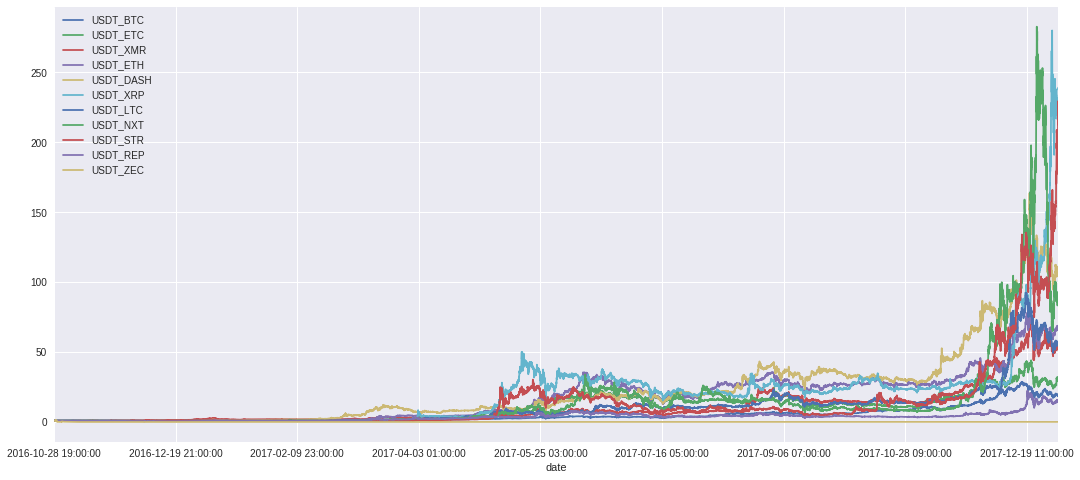

In [43]:
crypto_df_norm = crypto_df.divide(crypto_df.iloc[0])
crypto_df_pct = crypto_df.pct_change().dropna()
corr = crypto_df_pct.corr()
crypto_df_norm.plot(figsize=(18,8))

0.31478999094614157

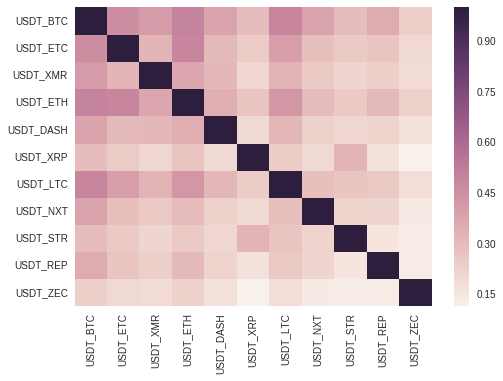

In [44]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
corr['USDT_XMR']['USDT_DASH']

In [ ]:
plt.scatter(crypto_df_pct['USDT_DASH'],crypto_df_pct['USDT_XMR'])
plt.xlabel('USDT_DASH % Return')
plt.ylabel('USDT_XMR % Return')

In [ ]:
import statsmodels.api as sm
model = sm.OLS(crypto_df_pct['USDT_XMR'],
               crypto_df_pct['USDT_DASH']).fit()
model.summary()

In [ ]:
line=[model.params[0]*i for i in crypto_df_pct['USDT_DASH'].values]
plt.plot(crypto_df_pct['USDT_DASH'], line, c = 'r')
plt.scatter(crypto_df_pct['USDT_DASH'],crypto_df_pct['USDT_XMR'])
plt.xlabel('USDT_DASH % Return')
plt.ylabel('USDT_XMR % Return')

In [ ]:
coin = 'LTC'
fiat = 'BTC'
ticker = '{:s}_{:s}'.format(fiat, coin)
frequency = 300
df = CryptoDataCSV(symbol = ticker, frequency = frequency)

In [ ]:
fpath = get_price_fpath(coin, fiat, c.POLONIEX, frequency)
df[ticker] = pd.read_csv(fpath, index_col = 'date')['close']
df['SMA_1000'] = df['close'].rolling(1000).mean()
df['SMA_5000'] = df['close'].rolling(5000).mean()
df[['close','SMA_1000','SMA_5000']][270000:].plot(figsize = (16,10))

In [ ]:
def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

In [ ]:
ma_df = test_ma(df, 1000, 5000).dropna()
ma_df['regime'].plot(figsize=(16,5))

In [ ]:
ma_df[['Market','Strategy']].iloc[-1]

In [ ]:
ma_df[['Market','Strategy']][200000:].plot(figsize = (16,10))

In [ ]:
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)

In [ ]:
for lead, lag in lead_lags:
    pnls[lead][lag] = test_ma(df, lead, lag)['Strategy'][-1]
    #print(lead,lag,pnls[lead][lag])

In [ ]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs, cmap='PiYG')
#PNLs.max()

In [ ]:
df.dropna().head()

## API

* https://poloniex.com/support/api/
* https://pypi.python.org/pypi/poloniex
* https://github.com/Aula13/poloniex
* https://github.com/s4w3d0ff/python-poloniex
* https://pastebin.com/fbkheaRb